## description
항공권을 검색하다보면 항공권의 가격이 시시각각 변하는 걸 목격한 경험이 있을것이다. 그러한 가격 책정 알고리즘의 근거는 profit의 최대화와 관련히 있다.여러가지 고객들의 로그 를 통해서 고객을 데이터를 분석하고 분석의 결과로 자사의 이익이 극대화되는 가격을 책정하는 것이 시시각각 변화하는 'dynamic pricing'의 기본 생각이다. Multi-armed-bandit(MAB) 를 이용하여 상품의 가격을 결정하는 최적의 알고리즘을 만들어보자

## related work

**Multi-armed-bandit(MAB)**
* 가격선택 알고리즘을 어떨걸로


**demand theory**
* 가격이 0이면 모두다 구매할것.
* 가격에 따라 수용하는 정도가 다 다름.
* 수요곡선은 우하향 하는 그래프(x축 가격, y축 수요)
* profit = demand x price

## 1. basic algorithm
* 개별 고객의 수요곡선은 unknown
* 상품은 한가지
* profit = price x demand
* 원가는 고려하지 않음
* 가격 선택과 그에 따른 피드백
* 가격을 최적화하는 과정임. 
* 전환율과 가격?

In [2]:
import numpy as np

In [82]:
# 전체 판매량으로 계산. 개별고객의 수요곡선 아님. 확률에 대한 함수
def demand_func(price):
    return np.exp(-np.array(price)*0.0001)

def profit_func(price, demand):
    return np.array(price) * demand

In [133]:
class MAB:
    """
    알고리즘에 의해 선택된 bandit을 draw하는 역할
    
    """
    
    def __init__(self, bandit_probs):
        self.bandit_probs = bandit_probs
        
     
    # reward,regret
    def draw(self):
        reward = np.random.binomial(1,self.bandit_probs)
        return reward

In [169]:
# 가격을 세팅했고, 피드백을 받은 상태.

def calculator(alpha,beta):
    """
    베타분포의 평균/분산 을 구하는 함수
    """
    mean = alpha/(alpha+beta)
    var = (alpha*beta)/(((alpha+beta)**2)*(alpha+beta+1))
    return mean, var

def param(success, fail):
    """
    베타분포 모수 계산 함수
    """
    alpha, beta = 1+success, 1+fail
    return alpha, beta

def thompson(success, fail):
    """
    지금까지의 정보로 다음 price를 정하는 함수
    """
    alpha, beta = param(success, fail)
    mean, var = calculator(alpha, beta)
    
    #thompson
    rvs = np.random.beta(alpha,beta)
    return rvs
    
    
def pricing(price,n, rvs):
    
    sort_price = np.sort(price)[::-1]
    profit =  n * rvs * price 
        
    k = np.argmax(profit)
    opt_price = price[k]
    
    
    # 다음 가격 정하기
    if sort_price[0] == opt_price :
        interval = sort_price[0] - sort_price[1]
              
        next_price = np.random.randint(np.max(opt_price-interval,0), opt_price, 2).tolist()+np.random.randint(opt_price, opt_price*1.2, 2).tolist() 
    
    elif sort_price[-1] == opt_price :
        interval = sort_price[-2] - sort_price[-1]
        
        next_price = np.random.randint(np.max(0,opt_price-interval), opt_price,2).tolist()+np.random.randint(opt_price, oprt_price+interval, 2).tolist() 
        
    else :
        
        lower, upper = price[k] - price[k-1], price[k+1] - price[k]
        next_price = np.random.randint(opt_price-lower, opt_price,2).tolist() + np.random.randint(opt_price,opt_price+upper,2).tolist()
        

    return np.sort(next_price), opt_price


In [154]:
n = 1000
price = [1000, 2000, 5000, 10000]
reward_array = np.zeros((len(price), n))
demand_func(price)

array([0.90483742, 0.81873075, 0.60653066, 0.36787944])

In [155]:
test = MAB(demand_func(price))

In [125]:
success = np.array([2,3,4,5])
fail = np.array([1,2,3,4])

rvs = thompson(success, fail)
price,opt_price = pricing(price,n,rvs)

In [189]:
demand = demand_func(new_price)

In [190]:
test = MAB(demand)

for i in range(n):
    reward_array[:,i] = test.draw()

In [191]:
success = reward_array.sum(axis=1)
fail = n - success

In [192]:
rvs = thompson(success, fail)
new_price,opt_price = pricing(new_price,n,rvs)

In [193]:
new_price

array([11001, 11037, 11100, 11100])

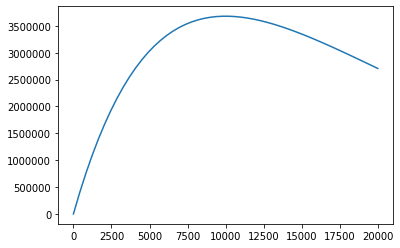

In [200]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,20000),demand_func(np.linspace(0,20000)) * n * np.linspace(0,20000))


### 문제점
* 다음가격을 선택하는 단계가 지저분함
* 

## 2.GP optimize
* 목적함수의 존재와 최적의 가격 선택
* input = price , output = 수요량.
* Thompson Sampling for Infinite-Armed Bandits

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_predict
from sklearn import datasets
from sklearn.metrics import r2_score
import pymc3 as pm

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('seaborn-darkgrid')

In [321]:
def obj_func(n,price):
    return np.exp(-np.array(price)*0.0001)*n*price

In [323]:
X_observed = np.random.uniform(0,50000, 10)[:,None]
Y_observed = obj_func(1000, X_observed)

In [337]:
# let us use the Matern kernel
K = 10*RBF(length_scale=1000)

# instance of GP
gp = GaussianProcessRegressor(kernel=K)

# fitting the GP
gp.fit(X_observed.reshape(-1,1), Y_observed)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=3.16**2 * RBF(length_scale=1e+03),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [338]:
# let us check the learned model over all of the input space
X_ = np.linspace(0, 50000, 500)
y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)

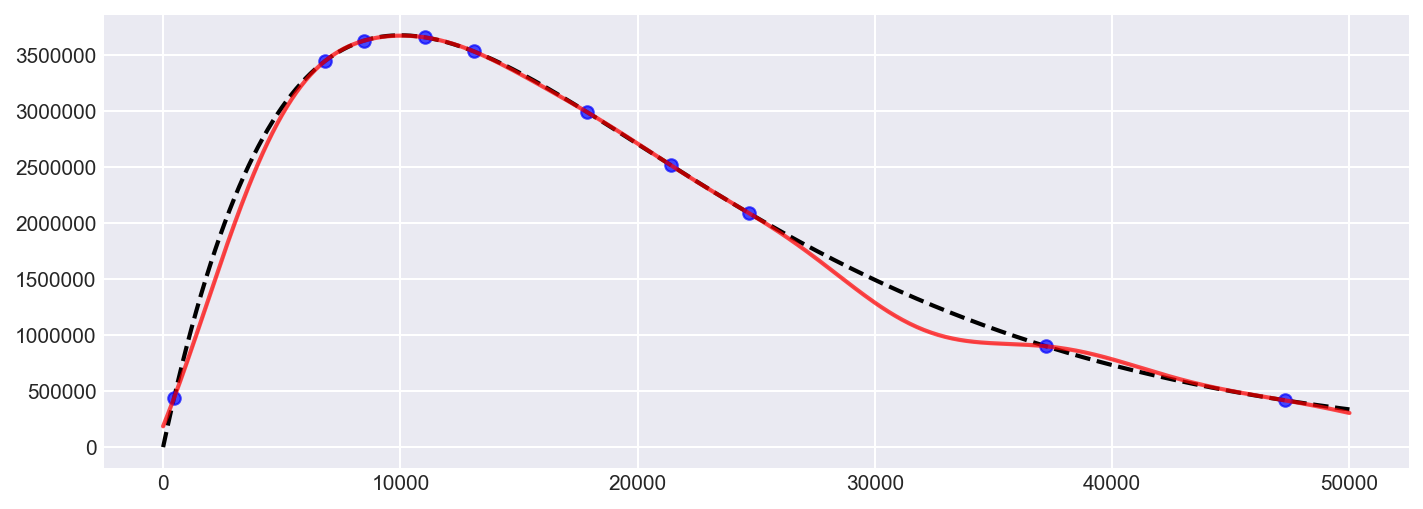

In [340]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[10,4], dpi=150)

# data
Y = obj_func(1000, X_)

# plotting
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');
plt.plot(X_observed, Y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=0.7)
plt.plot(X_, y_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(X_, y_mean.flatten()- y_std, y_mean.flatten() + y_std, alpha=0.2, color='r')
plt.show()

In [310]:
class thompsonGP:
    
    def __init__(self, n_random_draws, objective, x_bound, interval_resolution=1000):
        self.n_random_draws = n_random_draws
        self.objective = objective
        self.bounds = x_bound
        self.interval_resolution = interval_resolution
        self.X_grid = np.linspace(self.bounds[0], self.bounds[1], self.interval_resolution)
        self.X, self.Y = np.array([]), np.array([])
        
    # 물건마다 다를듯, 또 고객군마다도    
    def fit(self, X, Y):
        K = RBF(length_scale=55)
        gp = GaussianProcessRegressor(kernel=K)
        gp.fit(X,Y)
        return gp
    
    def choose_next_sample(self):
        
        if self.X.shape[0] < self.n_random_draws:
            next_sample = np.random.uniform(self.bounds[0], self.bounds[1],1)[0]
            
        else : 
            # GP fit
            self.gp = self.fit(self.X.reshape(-1,1), self.Y)
            
            # sampling 주어진 점을 토대로 샘플링
            posterior_sample = self.gp.sample_y(self.X_grid.reshape(-1,1), 1).T[0]
            
            which_max = np.argmax(posterior_sample)
            next_sample = self.X_grid[which_max]
            
            posterior_mean , posterior_std = self.gp.predict(self.X_grid.reshape(-1,1), return_std=True)
        
        next_observation = self.objective(1000, next_sample)
        self.X = np.append(self.X, next_sample)
        self.Y = np.append(self.Y, next_observation)
        
        try :
            return self.X, self.Y, self.X_grid, posterior_sample, posterior_mean, posterior_std
        
        except:
            return self.X, self.Y, self.X_grid, np.array([np.mean(self.Y)]*self.interval_resolution), np.array([np.mean(self.Y)]*self.interval_resolution), np.array([0]*self.interval_resolution) 

In [317]:
ts_gp = thompsonGP(n_random_draws=10, objective=obj_func, x_bound = (0,50000))

In [318]:
for i in range(20):
    X_observed, y_observed, X_grid, posterior_sample, posterior_mean, posterior_std = ts_gp.choose_next_sample()

C:\Users\dhdcj\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\dhdcj\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\dhdcj\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\dhdcj\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\dhdcj\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those v

In [320]:
ts_gp.X

array([20888.24049746, 29955.30050319, 44386.8491606 ,  7372.97550144,
        6122.838335  , 10956.88920361, 40062.61315506, 35131.1024553 ,
       20482.59272817, 43488.59546955,  9909.90990991,  9959.95995996,
       10010.01001001, 10010.01001001, 10010.01001001, 10010.01001001,
       10010.01001001, 10010.01001001, 10010.01001001, 10010.01001001])